## 第7章  4 GRU网络进行情感分类

**Daitu：2505131775@qq.com**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time
import copy


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchtext import data
from torchtext.vocab import Vectors

###  数据准备

In [3]:
## 使用torchtext库进行数据准备
# 定义文件中对文本和标签所要做的操作

## 定义文本切分方法，直接使用空格切分即可
mytokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=mytokenize, 
                  include_lengths=True, use_vocab=True,
                  batch_first=True, fix_length=200)
LABEL = data.Field(sequential=False, use_vocab=False, 
                   pad_token=None, unk_token=None)
## 对所要读取的数据集的列进行处理
train_test_fields = [
    ("label", LABEL), # 对标签的操作
    ("text", TEXT) # 对文本的操作
]
## 读取数据
traindata,testdata = data.TabularDataset.splits(
    path="./data/chap6", format="csv", 
    train="imdb_train.csv", fields=train_test_fields, 
    test = "imdb_test.csv", skip_header=True
)

In [4]:
len(traindata),len(testdata)

(25000, 25000)

In [5]:
# ## 加载预训练的词向量和构建词汇表
## Vectors导入预训练好的词向量文件
vec = Vectors("glove.6B.100d.txt", "./data")
# ## 使用训练集构建单词表，导入预先训练的词嵌入
TEXT.build_vocab(traindata,max_size=20000,vectors = vec)
# TEXT.build_vocab(traindata,max_size=20000)
LABEL.build_vocab(traindata)
## 训练集、验证集和测试集定义为迭代器
BATCH_SIZE = 32
train_iter = data.BucketIterator(traindata,batch_size = BATCH_SIZE)
test_iter = data.BucketIterator(testdata,batch_size = BATCH_SIZE)

In [6]:
##  获得一个batch的数据，对数据进行内容进行介绍
for step, batch in enumerate(train_iter):  
    textdata,target = batch.text[0],batch.label
    if step > 0:
        break

In [7]:
print(textdata.shape)
print(target.shape)

torch.Size([32, 200])
torch.Size([32])


### 构建GRU网络，和LSTM网络结构相似

In [8]:
class GRUNet(nn.Module):
    def __init__(self, vocab_size,embedding_dim, hidden_dim, layer_dim, output_dim):
        """
        vocab_size:词典长度
        embedding_dim:词向量的维度
        hidden_dim: GRU神经元个数
        layer_dim: GRU的层数
        output_dim:隐藏层输出的维度(分类的数量)
        """
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim ## GRU神经元个数
        self.layer_dim = layer_dim ## GRU的层数
        ## 对文本进行词项量处理
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM ＋ 全连接层
        self.gru = nn.GRU(embedding_dim, hidden_dim, layer_dim,
                          batch_first=True)
        self.fc1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        embeds = self.embedding(x)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size) 
        r_out, h_n = self.gru(embeds, None)   # None 表示初始的 hidden state 为0
        # 选取最后一个时间点的out输出
        out = self.fc1(r_out[:, -1, :]) 
        return out
    

In [9]:
## 初始化网络
vocab_size = len(TEXT.vocab)
embedding_dim = vec.dim #  词向量的维度
# embedding_dim = 128 #  词向量的维度
hidden_dim = 128
layer_dim = 1
output_dim = 2
grumodel = GRUNet(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim)
grumodel

GRUNet(
  (embedding): Embedding(20002, 100)
  (gru): GRU(100, 128, batch_first=True)
  (fc1): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [10]:
## 将导入的词项量作为embedding.weight的初始值
grumodel.embedding.weight.data.copy_(TEXT.vocab.vectors)
## 将无法识别的词'<unk>', '<pad>'的向量初始化为0
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
grumodel.embedding.weight.data[UNK_IDX] = torch.zeros(vec.dim)
grumodel.embedding.weight.data[PAD_IDX] = torch.zeros(vec.dim)

In [11]:
## 定义网络的训练过程函数
def train_model(model,traindataloader, testdataloader,criterion, 
                optimizer,num_epochs=25):
    """
    model:网络模型；traindataloader:训练数据集;valdataloader:验证数据集;
    criterion:损失函数;optimizer:优化方法;
    num_epochs:训练的轮数,scheduler:学习率变化器
    """
    train_loss_all = []
    train_acc_all = []
    test_loss_all = []
    test_acc_all = []
    learn_rate = []
    since = time.time()
    ## 设置等间隔调整学习率,每隔step_size个epoch,学习率缩小10倍
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 
    for epoch in range(num_epochs):
        learn_rate.append(scheduler.get_lr()[0])
        print('-' * 10)
        print('Epoch {}/{},Lr:{}'.format(epoch, num_epochs - 1,learn_rate[-1]))
        # 每个epoch有两个阶段,训练阶段和验证阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        test_loss = 0.0
        test_corrects = 0
        test_num = 0
        model.train() ## 设置模型为训练模式
        for step,batch in enumerate(traindataloader):
            textdata,target = batch.text[0],batch.label
            out = model(textdata)
            pre_lab = torch.argmax(out,1) # 预测的标签
            loss = criterion(out, target) # 计算损失函数值
            optimizer.zero_grad()        
            loss.backward()       
            optimizer.step()  
            train_loss += loss.item() * len(target)
            train_corrects += torch.sum(pre_lab == target.data)
            train_num += len(target)
        ## 计算一个epoch在训练集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        print('{} Train Loss: {:.4f}  Train Acc: {:.4f}'.format(
            epoch, train_loss_all[-1], train_acc_all[-1]))
        scheduler.step()  ## 更新学习率
        ## 计算一个epoch的训练后在验证集上的损失和精度
        model.eval() ## 设置模型为训练模式评估模式 
        for step,batch in enumerate(testdataloader):
            textdata,target = batch.text[0],batch.label
            out = model(textdata)
            pre_lab = torch.argmax(out,1)
            loss = criterion(out, target)   
            test_loss += loss.item() * len(target)
            test_corrects += torch.sum(pre_lab == target.data)
            test_num += len(target)
        ## 计算一个epoch在训练集上的损失和精度
        test_loss_all.append(test_loss / test_num)
        test_acc_all.append(test_corrects.double().item()/test_num)
        print('{} Test Loss: {:.4f}  Test Acc: {:.4f}'.format(
            epoch, test_loss_all[-1], test_acc_all[-1]))
        
    train_process = pd.DataFrame(
        data={"epoch":range(num_epochs),
              "train_loss_all":train_loss_all,
              "train_acc_all":train_acc_all,
              "test_loss_all":test_loss_all,
              "test_acc_all":test_acc_all,
              "learn_rate":learn_rate})  
    return model,train_process

In [12]:
# 定义优化器
optimizer = optim.RMSprop(grumodel.parameters(), lr=0.003)  
loss_func = nn.CrossEntropyLoss()  # 交叉熵作为损失函数
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
grumodel,train_process = train_model(
    grumodel,train_iter,test_iter,loss_func,optimizer,num_epochs=10)

----------
Epoch 0/9,Lr:0.003
0 Train Loss: 0.4883  Train Acc: 0.7222
0 Test Loss: 0.2907  Test Acc: 0.8829
----------
Epoch 1/9,Lr:0.003
1 Train Loss: 0.2216  Train Acc: 0.9166
1 Test Loss: 0.2968  Test Acc: 0.8804
----------
Epoch 2/9,Lr:0.003
2 Train Loss: 0.1107  Train Acc: 0.9613
2 Test Loss: 0.5522  Test Acc: 0.8563
----------
Epoch 3/9,Lr:0.003
3 Train Loss: 0.0463  Train Acc: 0.9863
3 Test Loss: 0.6375  Test Acc: 0.8507
----------
Epoch 4/9,Lr:0.003
4 Train Loss: 0.0193  Train Acc: 0.9949
4 Test Loss: 0.6792  Test Acc: 0.8509
----------
Epoch 5/9,Lr:3.0000000000000004e-05
5 Train Loss: 0.0048  Train Acc: 0.9986
5 Test Loss: 1.2510  Test Acc: 0.8473
----------
Epoch 6/9,Lr:0.00030000000000000003
6 Train Loss: 0.0014  Train Acc: 0.9997
6 Test Loss: 1.4834  Test Acc: 0.8500
----------
Epoch 7/9,Lr:0.00030000000000000003
7 Train Loss: 0.0006  Train Acc: 0.9999
7 Test Loss: 1.9099  Test Acc: 0.8484
----------
Epoch 8/9,Lr:0.00030000000000000003
8 Train Loss: 0.0003  Train Acc: 0.999

In [13]:
## 输出结果保存和数据保存
torch.save(grumodel,"data/chap7/grumodel.pkl")
## 导入保存的模型
grumodel = torch.load("data/chap7/grumodel.pkl")
grumodel
## 保存训练过程
train_process.to_csv("data/chap7/grumodel_process.csv",index=False)
train_process

/Users/daitu/anaconda3/envs/python35/lib/python3.5/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GRUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


,epoch,learn_rate,test_acc_all,test_loss_all,train_acc_all,train_loss_all
0,0,0.00300,0.88288,0.290720,0.72224,0.488328
1,1,0.00300,0.88036,0.296820,0.91664,0.221609
2,2,0.00300,0.85632,0.552171,0.96132,0.110719
3,3,0.00300,0.85072,0.637472,0.98632,0.046262
4,4,0.00300,0.85092,0.679195,0.99488,0.019270
5,5,0.00003,0.84732,1.250990,0.99864,0.004793
6,6,0.00030,0.84996,1.483420,0.99972,0.001356
7,7,0.00030,0.84844,1.909921,0.99992,0.000632
8,8,0.00030,0.84900,2.282225,0.99992,0.000299
9,9,0.00030,0.84760,2.695903,1.00000,0.000002


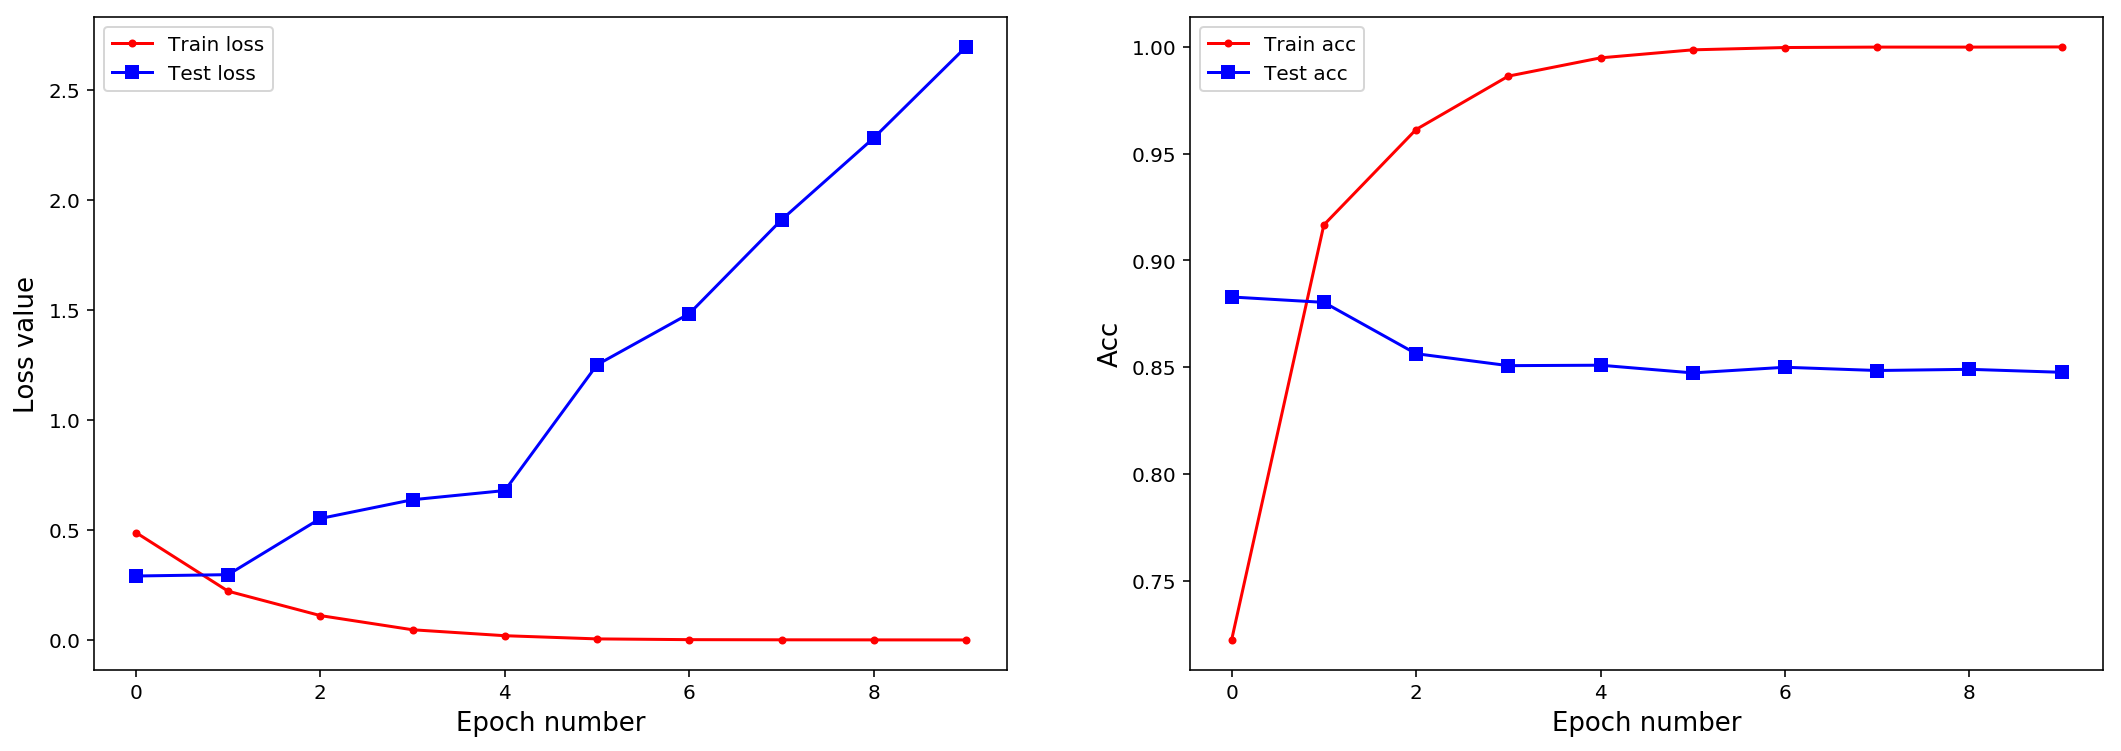

In [14]:
## 可视化模型训练过程中
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,
         "r.-",label = "Train loss")
plt.plot(train_process.epoch,train_process.test_loss_all,
         "bs-",label = "Test loss")
plt.legend()
plt.xlabel("Epoch number",size = 13)
plt.ylabel("Loss value",size = 13)
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,
         "r.-",label = "Train acc")
plt.plot(train_process.epoch,train_process.test_acc_all,
         "bs-",label = "Test acc")
plt.xlabel("Epoch number",size = 13)
plt.ylabel("Acc",size = 13)
plt.legend()
plt.show()

In [15]:
## 对测试集进行预测并计算精度
grumodel.eval() ## 设置模型为训练模式评估模式 
test_y_all = torch.LongTensor()
pre_lab_all = torch.LongTensor()
for step,batch in enumerate(test_iter):
    textdata,target = batch.text[0],batch.label.view(-1)
    out = grumodel(textdata)
    pre_lab = torch.argmax(out,1)
    test_y_all = torch.cat((test_y_all,target)) ##测试集的标签
    pre_lab_all = torch.cat((pre_lab_all,pre_lab))##测试集的预测标签

acc = accuracy_score(test_y_all,pre_lab_all)
print("在测试集上的预测精度为:",acc)

在测试集上的预测精度为: 0.8476
